In [1]:
''' 
this conda script will call other scripts to do the follow tasks

(1) have a function to load the control test set images
(2) have a function to load the universally perturbed test set images
(3) have a function to grab the other holdout training images
(4) train an autoencoder with the holdout training images
(5) have a function for testing a network on any input and output

'''

import numpy
import scipy
from scipy import ndimage
from os.path import expanduser
import tensorflow as tf
from PIL import Image
import cPickle as pickle
import os
import glob
from numpy import random
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, expanduser('~/adversary/src/models'))
sys.path.insert(0, expanduser('~/TensorFlow-Tutorials'))


import tf_builder
import cifar10_load
import tf_utils
from sklearn.decomposition import PCA

/home/davis/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def extractLabels(filename):
    labels = open(expanduser(filename));
    labels_list = [];
    for label in labels:
        labels_list.append(int(label[:-1])-1);
    return labels_list

def extractData(directoryname):
    
    # size of image dataset
    num_images = len(glob.glob1(expanduser(directoryname),"*.JPEG"))
    # return numpy image array
    images = []
    images_names = []
    
    # for each image in directory, grab and crop and save to pickle
    for imagefile in os.listdir(expanduser(directoryname)):
        if(imagefile[-4:] == 'JPEG' or imagefile[-4:] == 'jpeg'):
            image = Image.open(expanduser(directoryname + '/' + imagefile))
            if(image.mode == 'RGB'):
                images.append(image.copy())
                images_names.append(imagefile)
            else:
                images.append(image.convert('RGB').copy())
                images_names.append(imagefile)
            image.close()
    
    return images, images_names

def resizeSet(images):
    resizedImages = [];
    for image in images:
        resizedImages.append(scipy.misc.imresize(image,(224,224,3), interp='bilinear'))
    return resizedImages

def listOfImagesToNumpy(imageList, labelList):
    returnArray = numpy.zeros((len(imageList),224,224,3))
    returnLabels = numpy.zeros((len(labelList),1000))
    
    for i in range(len(imageList)):
        returnArray[i,:,:,:]=numpy.reshape(scipy.misc.imresize(numpy.asarray(imageList[i]),(224,224,3), interp='bilinear'), (224,224,3))
        returnLabels[i,labelList[i]] = 1
    
    
    return returnArray, returnLabels

def loadControl():
    pathname_data = '~/adversary/data/data_control'
    pathname_label = '~/adversary/data/labels_control.txt'
    
    image_list, name_list = extractData(pathname_data)
    label_list = extractLabels(pathname_label)
    images = resizeSet(image_list)
    
    images_final, labels_final = listOfImagesToNumpy(images, label_list)
    
    return images_final, labels_final

def loadUniversal():
    pathname_data = '~/adversary/data/data_universal'
    pathname_label = '~/adversary/data/labels_universal.txt'
    
    image_list, name_list = extractData(pathname_data)
    label_list = extractLabels(pathname_label)
    images = resizeSet(image_list)
    
    images_final, labels_final = listOfImagesToNumpy(images, label_list)
    
    return images_final, labels_final

def flatten(input):
    flat_size = input.shape[1]*input.shape[2]*input.shape[3]
    return_arr = numpy.zeros((len(input),flat_size))
    for i in range(len(input)):
        return_arr[i,:] = numpy.reshape(input[i], (flat_size))
    return return_arr

def unflatten(input):
    return_arr = numpy.zeros((len(input),224,224,3))
    for i in range(len(input)):
        return_arr[i,:,:,:] = numpy.reshape(input[i], (224,224,3))
    return return_arr

In [7]:
image_control, label_control = loadControl()
data = flatten(image_control)

In [4]:
image_universal, label_universal = loadUniversal()

In [29]:
pca = PCA(n_components = 2000)

In [30]:
pca.fit(data)

PCA(copy=True, iterated_power='auto', n_components=2000, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [31]:
sum(pca.explained_variance_ratio_)

0.99999999999999956

In [32]:
im = pca.transform(data[0])

/home/davis/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [33]:
rev = pca.inverse_transform(im)

In [34]:
dat = unflatten(rev)

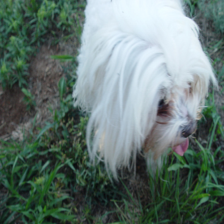

In [35]:
Image.fromarray(numpy.uint8(numpy.asarray(numpy.reshape(dat, [224,224,3]))))